<a href="https://colab.research.google.com/github/ghazalna/Demand-Forecasting-and-Inventory-Optimization/blob/main/inventory_forecasting__with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inventory Forecasting with LSTM**

## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout


## **Load Data**

In [2]:
data = pd.read_csv("demand_inventory.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


## **PreProcessing**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  62 non-null     int64 
 1   Date        62 non-null     object
 2   Product_ID  62 non-null     object
 3   Demand      62 non-null     int64 
 4   Inventory   62 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.5+ KB


In [4]:
# Drop the 'Unnamed: 0' column
data = data.drop(columns=['Unnamed: 0'])

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by Date (if not already sorted)
data = data.sort_values('Date')


In [5]:
data

,Date,Product_ID,Demand,Inventory
0,2023-06-01,P1,51,5500
1,2023-06-02,P1,141,5449
2,2023-06-03,P1,172,5308
3,2023-06-04,P1,91,5136
4,2023-06-05,P1,198,5045
...,...,...,...,...
57,2023-07-28,P1,174,0
58,2023-07-29,P1,72,0
59,2023-07-30,P1,52,0
60,2023-07-31,P1,188,0


## **visualize the Demand Over Time**

In [6]:
fig_demand = px.line(data, x='Date',
                     y='Demand',
                     title='Demand Over Time')
fig_demand.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


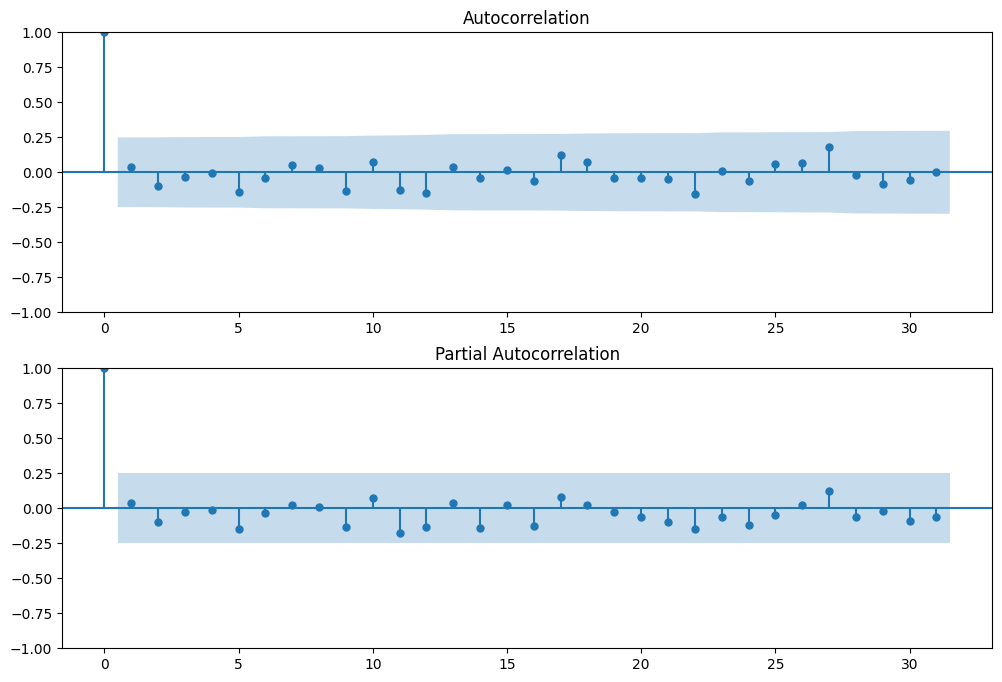

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Determine the maximum number of lags allowed (50% of the length of the data)
max_lags = len(data['Demand']) // 2

# Plot ACF and PACF with the adjusted maximum number of lags
fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(data['Demand'], lags=max_lags, ax=ax[0])
plot_pacf(data['Demand'], lags=max_lags, ax=ax[1])
plt.show()


## **Visualize the Inventory Over Time**

In [8]:
fig_inventory = px.line(data, x='Date',
                        y='Inventory',
                        title='Inventory Over Time')
fig_inventory.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## **Normalize the Data**

In [10]:
# Normalize the Inventory column
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Inventory']])

# Convert normalized data back to DataFrame for easier manipulation
data_scaled_df = pd.DataFrame(data_scaled, columns=['Inventory'])


In [11]:
data_scaled_df

,Inventory
0,1.000000
1,0.990727
2,0.965091
3,0.933818
4,0.917273
...,...
57,0.000000
58,0.000000
59,0.000000
60,0.000000


## **Create training and testing datasets**

In [12]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Set the sequence length
sequence_length = 5

# Create sequences from the normalized data
X, y = create_sequences(data_scaled, sequence_length)


In [13]:
# Split the sequences into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (45, 5, 1)
y_train shape: (45, 1)
X_test shape: (12, 5, 1)
y_test shape: (12, 1)


## **Define the LSTM model**

In [14]:
# Define the LSTM model
model = Sequential()

# Add Input layer specifying the shape
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Add LSTM layer(s)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))

# Add Dense layer for output
model.add(Dense(1))  # Single output for Inventory

# Compile the model
optimizer = Adam(learning_rate=0.0003)  # Lower learning rate
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

# Early stopping callback to stop training when the model isn't improving
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Learning rate reducer callback to decrease the learning rate when a plateau is reached
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

## **Train the Model**

In [15]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=300,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 630ms/step - accuracy: 0.2863 - loss: 0.1796 - val_accuracy: 0.2500 - val_loss: 0.2159 - learning_rate: 0.0010
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2863 - loss: 0.1442 - val_accuracy: 0.2500 - val_loss: 0.1729 - learning_rate: 0.0010
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2551 - loss: 0.1146 - val_accuracy: 0.2500 - val_loss: 0.1283 - learning_rate: 0.0010
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2759 - loss: 0.0904 - val_accuracy: 0.2500 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2968 - loss: 0.0559 - val_accuracy: 0.2500 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2863 - loss: 0.0310 - val_accuracy: 0.2500 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2863 - loss: 0.0222 - val_accuracy:

In [16]:
# Generate predictions from the model
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
# Note: The scaler was fitted on both 'Demand' and 'Inventory'
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


## **Evaluate the Model**

In [17]:
# Calculate metrics
rmse_inventory = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae_inventory = mean_absolute_error(y_test_actual, y_pred_actual)
r2_inventory = r2_score(y_test_actual, y_pred_actual)

print(f'Inventory - Root Mean Squared Error: {rmse_inventory}')
print(f'Inventory - Mean Absolute Error: {mae_inventory}')
print(f'Inventory - R2 Score: {r2_inventory}')

Inventory - Root Mean Squared Error: 75.30132963672347
Inventory - Mean Absolute Error: 60.469164848327615
Inventory - R2 Score: 0.9981977152816087


## **Inverse Transform Prediction**

In [18]:
# Inverse transform the predictions and actual values

y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

print(y_test_actual)
print(y_pred_actual)


[[4847.]
 [4325.]
 [1383.]
 [3158.]
 [ 854.]
 [   0.]
 [1654.]
 [1275.]
 [   0.]
 [3354.]
 [   0.]
 [4629.]]
[[4934.7036  ]
 [4281.347   ]
 [1418.5208  ]
 [3223.5388  ]
 [1024.4514  ]
 [  16.080767]
 [1755.3259  ]
 [1300.6171  ]
 [  42.29059 ]
 [3374.426   ]
 [  16.080767]
 [4528.0586  ]]


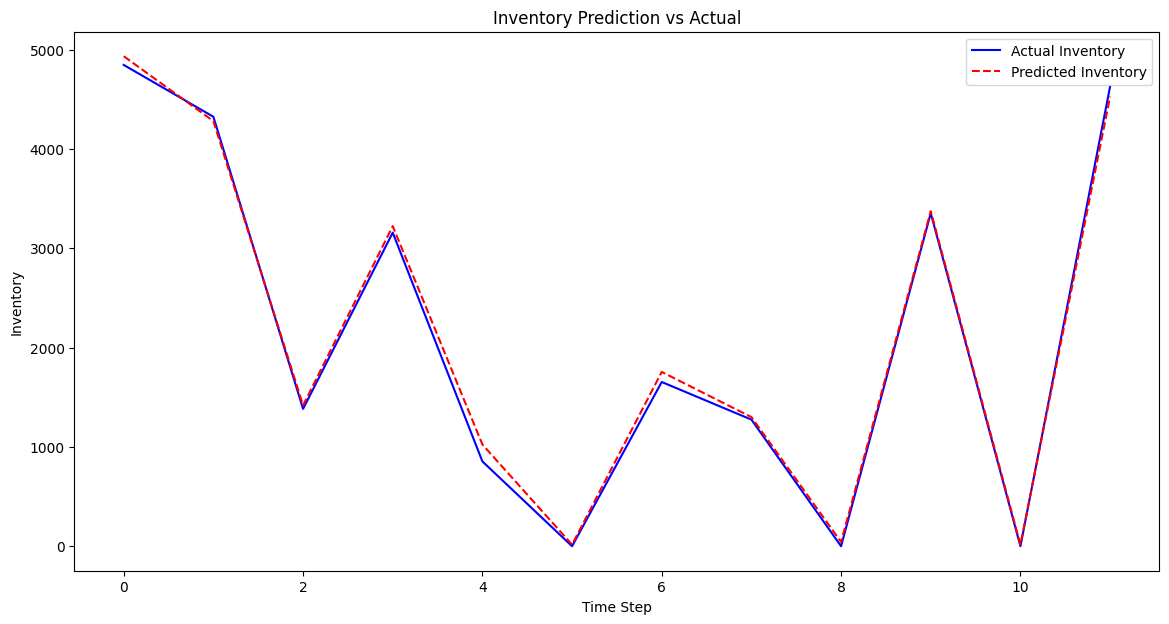

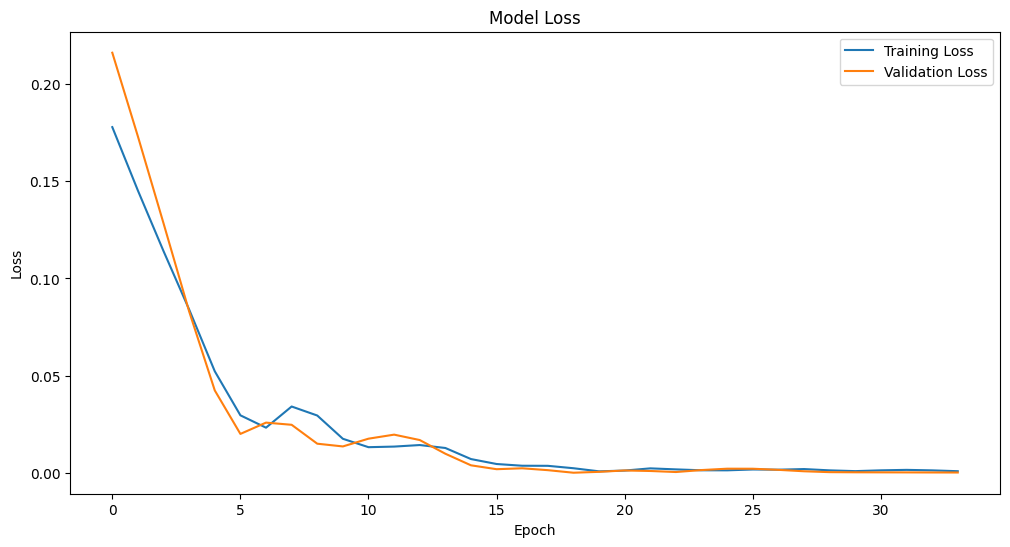

In [19]:
# Define a function for visualization
def plot_results(y_actual, y_pred, feature_name):
    plt.figure(figsize=(14, 7))
    plt.plot(y_actual, color='blue', label=f'Actual {feature_name}')
    plt.plot(y_pred, color='red', linestyle='dashed', label=f'Predicted {feature_name}')
    plt.title(f'{feature_name} Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel(feature_name)
    plt.legend()
    plt.show()

# Plot results for Inventory
plot_results(y_test_actual, y_pred_actual, 'Inventory')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
